# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «###» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Основные шаги:**
1. Загрузка данных.
2. Изучение данных. 
3. Подготовка выборки для обучения моделей.
4. Обучение разных моделей, одна из которых — LightGBM, как минимум одна — не бустинг.
5. Анализ времени обучения, времени предсказания и качества моделей.
6. Опираясь на критерии заказчика, выбор лучшей модели, проверка её качества на тестовой выборке.

**Описание данных**

Данные находятся в файле `###.csv`.

Признаки:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак
- `Price` — цена (евро)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1">Обзор данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1">Вывод</a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2">Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1">Вывод</a></span></li></ul></li><li><span><a href="#Корреляция-данных" data-toc-modified-id="Корреляция-данных-3">Корреляция данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1">Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4">Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1">Вывод</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-5">Анализ моделей</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5.1">Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6">Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7">Чек-лист проверки</a></span></li></ul></div>

## Обзор данных

In [1]:
!pip install phik
!pip install lightgbm

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [4]:
try:
    data = pd.read_csv('###.csv') 
except:
    data = pd.read_csv('https:###.csv')

In [5]:
# Функция для получения общей информации о датасете
def get_info(data):
    display(data.head())
    print('')
    display(data.info())
    print('')
    display(data.describe().T)
    print('')
    print('Количество явных дубликатов:', data.duplicated().sum())
    print('Количество пропусков:\n', data.isna().sum())

In [6]:
get_info(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object

None

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0



Количество явных дубликатов: 4
Количество пропусков:
 DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


###  Вывод

1. **Объем данных**:
   - В датасете содержится 354,369 объявлений о продаже автомобилей.
   - Данные содержат 16 признаков, включая информацию о цене, характеристиках автомобиля, датах и местоположении.

2. **Пропуски данных**:
     - `VehicleType` (37,490 пропусков)
     - `Repaired` (71,154 пропусков)
     - `FuelType` (32,895 пропусков)
     - `Gearbox` (19,833 пропусков)
     - `Model` (19,705 пропусков)

3. **Дубликаты**:
   - Обнаружено всего 4 явных дубликата.

4. **Анализ числовых признаков**:
   - **Price (цена)**:
     - Средняя цена составляет около 4,416, но есть значительный разброс (std=4,514).
     - Минимальная цена равна 0, что может указывать на ошибки или нестандартные предложения (например, дарение).
     - 75% объявлений имеют цену до 6,400, но максимальная цена достигает 20,000.
   - **RegistrationYear (год регистрации)**:
     - Средний год регистрации - 2004, но есть аномалии (min=1000, max=9999), которые требуют очистки.
   - **Power (мощность двигателя в л.с.)**:
     - Средняя мощность - 110 л.с., но есть экстремальные значения (max=20,000), которые явно ошибочны.
   - **Kilometer (пробег)**:
     - Средний пробег - 128,211 км, при этом 75% автомобилей имеют пробег 150,000 км или меньше.
   - **NumberOfPictures**:
     - Все значения равны 0, что делает этот признак бесполезным для анализа.

5. **Типы данных**
   - Временные данные следует преобразовать из строкового формата в `datetime`.  

## Подготовка данных

In [7]:
# перевод названий столбцов в змеиный регистр
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in data.columns]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [9]:
data.drop_duplicates(inplace=True)

Признаки, которые не помогут в определении стоимости:
- `date_crawled` - Дата скачивания анкеты не может влиять на стоимость автомобиля. Отметим, что анкеты выгружались в 2016 году.
- `registration_month` - порядковый номер месяца регистрации автомобиля.
- `date_created` - Точная дата публикации.
- `number_of_pictures` - Столбец не заполнен, во всех строках стоят нули.
- `last_seen` - Дата последней активности пользователя не может влиять на стоимость автомобиля.
- `postal_code` - Почтовый индекс владельца анкеты. Судя по индексам, владельцы авто из Германии.

In [10]:
#удаление столбцы, которые нам не понадобятся
data = data.drop(['number_of_pictures', 'postal_code', 
                  'date_created', 'last_seen', 
                  'registration_month', 'date_crawled'], axis=1)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       316875 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            334532 non-null  object
 4   power              354365 non-null  int64 
 5   model              334660 non-null  object
 6   kilometer          354365 non-null  int64 
 7   fuel_type          321470 non-null  object
 8   brand              354365 non-null  object
 9   repaired           283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [12]:
selected_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']  # Замените на ваши столбцы

# Проверяем, что во всех 5 столбцах строки имеют пропуски
rows_with_all_missing = data[selected_columns].isna().all(axis=1).sum()

print(f"Количество строк с пропусками во всех 5 выбранных столбцах: {rows_with_all_missing}")


Количество строк с пропусками во всех 5 выбранных столбцах: 2237


In [13]:
# Заполним пропуски заглушкой 'unknown'
data[selected_columns] = data[selected_columns].fillna('unknown')

In [14]:
#колонки, содержащие категориальные переменные
cat_col = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [15]:
for column in cat_col:
    print(f"\nУникальные значения в столбце '{column}':")
    print(data[column].unique())


Уникальные значения в столбце 'vehicle_type':
['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']

Уникальные значения в столбце 'gearbox':
['manual' 'auto' 'unknown']

Уникальные значения в столбце 'model':
['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_rei

In [16]:
# переименуем gasoline в petrol, поскольку оба означают "бензин"
data['fuel_type'] = data['fuel_type'].replace(['gasoline'],'petrol')

**Обработка выбросов**

In [17]:
def hist_box(df, column):
    plt.figure(figsize=(15, 5))
    
    # Количество интервалов (bins) будет рассчитано как квадратный корень из числа наблюдений
    num_bins = int(np.sqrt(len(df[column])))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(df[column], bins=num_bins)  # Используем количество интервалов num_bins

    # Диаграмма размаха
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.title(f'Диаграмма размаха для "{column}"')
    sns.boxplot(x=df[column])
    
    plt.tight_layout()
    plt.show()

In [18]:
def subplot(df, column):
    plt.figure(figsize=(30, 5))
    plt.subplot(1, 2, 2)
    plt.title(f'Столбчатая диаграмма для {column}')
    sns.countplot(data=df, x=column)
    plt.xlabel(f'{column}')
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()

In [19]:
#cat_col = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
discret_col = ['registration_year', 'kilometer']
num_col = ['price', 'power'] 

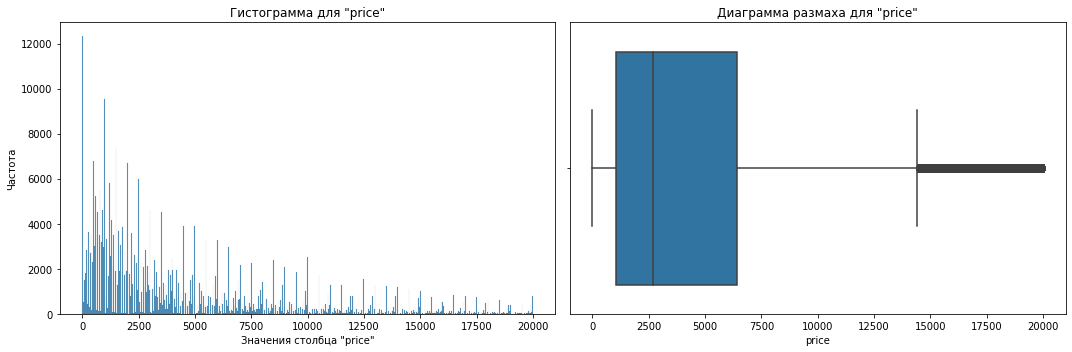

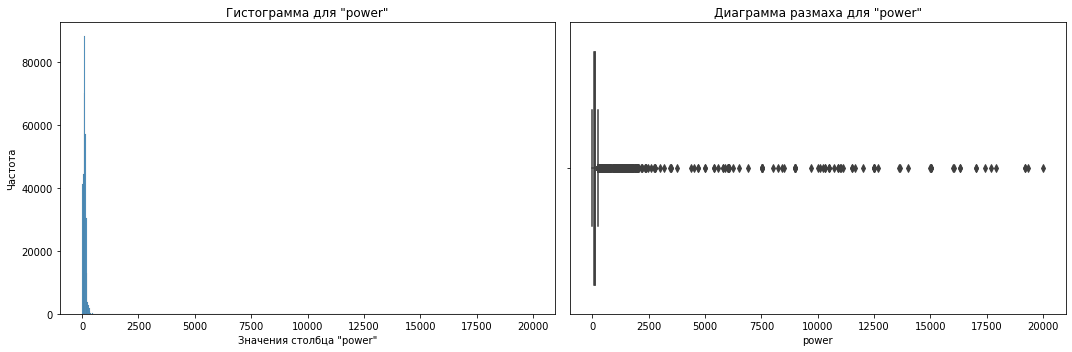

In [20]:
for name in num_col:
    hist_box(data, name)

Цена автомобилей распределена от 0 до 20000, судя по почтовым индексам, авто продаются в Германии, следовательно в евро. В "Авито" минимальная цена битых автомобилей примерно 10000 рублей - 100 евро. Удалим наблюдения дешевле 100 евро. Выбросы от 15000 до 20000 оставим, вероятно это цена автомобилей сегмента люкс.

In [21]:
# Подсчёт строк с price < 100
count = data[data['price'] < 100].shape[0]

# Вывод результата
print(f"Количество строк с price < 100: {count}")

Количество строк с price < 100: 13314


In [22]:
data = data.query('price >= 100')

Мощность автомобилей также распределена от 0 до 20000. Из информации интернета, самые мощные автомобили достагают мощности примерно 2000 л.с, самые слабые - 10 л.с. Удалим наблюдения, выходящие за эти границы.

In [23]:
data = data.query('10 <= power <= 2000')

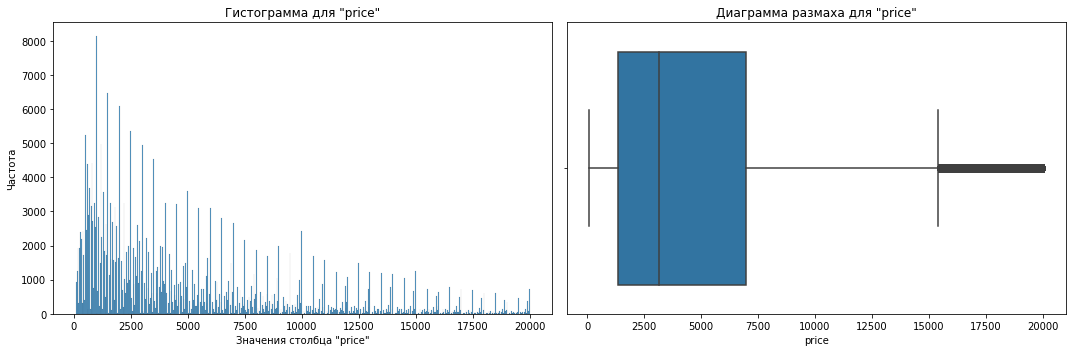

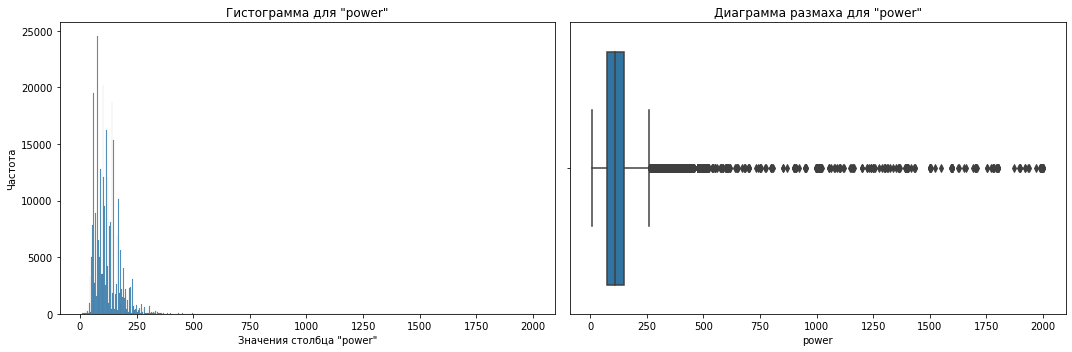

In [24]:
for name in num_col:
    hist_box(data, name)

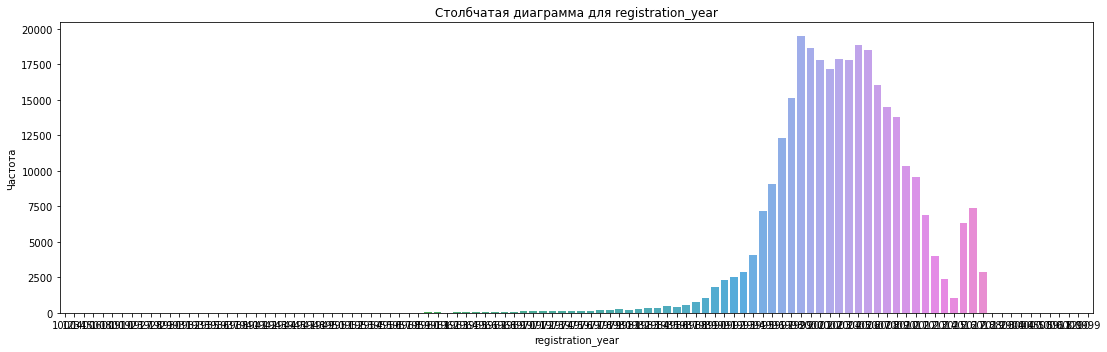

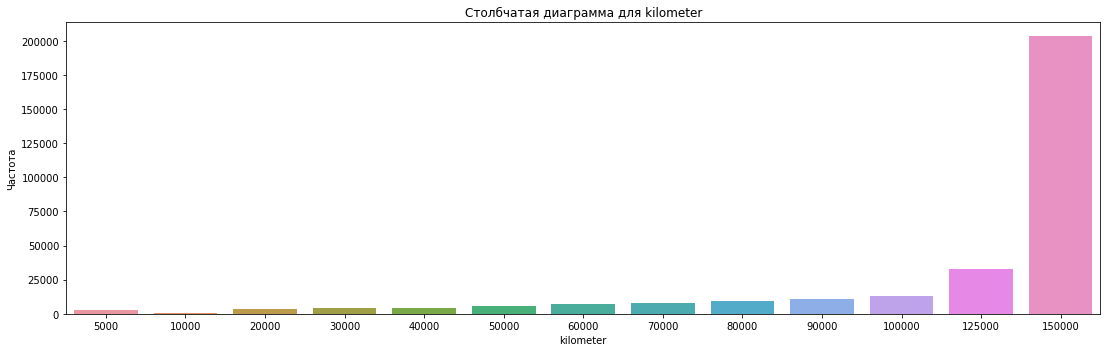

In [25]:
#построение распределений дискретных признаков датасета 
for name in discret_col:
    subplot(data, name)

В признаке `registration_year` встречаются неправдаподобные выбросы от 1000 до 9999 года. Судя по параметру `date_crawled` анкеты выгружались в 2016 году, поэтому отбросим 1 процент наименьших значений и значения, позже 2016 года.

In [26]:
data.registration_year.describe().to_frame()

,registration_year
count,305675.000000
mean,2003.494211
std,29.751948
min,1000.000000
25%,1999.000000
50%,2003.000000
75%,2008.000000
max,9999.000000


In [27]:
low_year = data['registration_year'].quantile(0.01)

In [28]:
data = data[(data['registration_year'] >= low_year) & (data['registration_year'] < 2017)]

In [29]:
data.registration_year.describe().to_frame()

,registration_year
count,292478.000000
mean,2003.125196
std,5.809461
min,1983.000000
25%,1999.000000
50%,2003.000000
75%,2007.000000
max,2016.000000


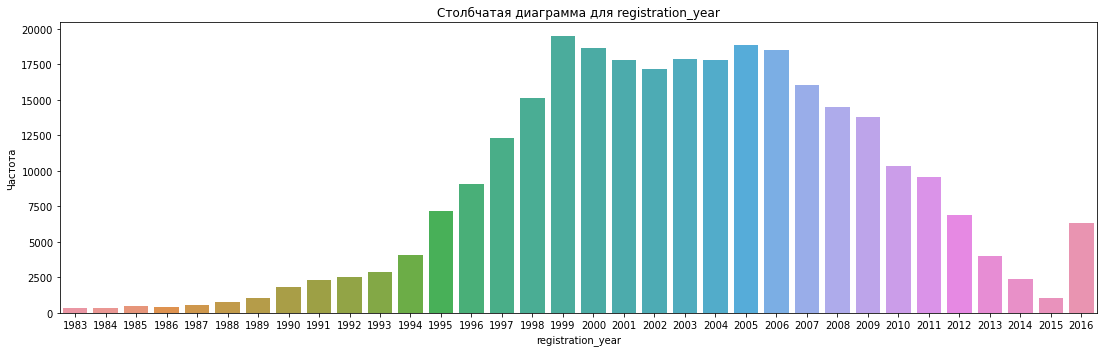

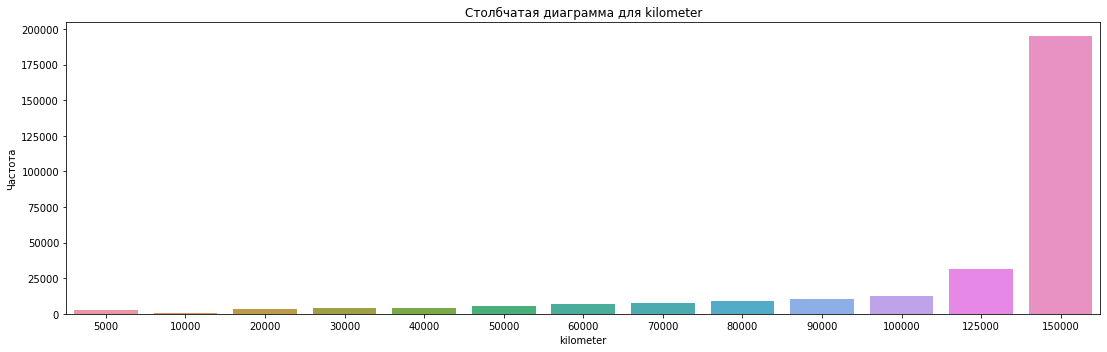

In [30]:
#построение распределений дискретных признаков датасета 
for name in discret_col:
    subplot(data, name)

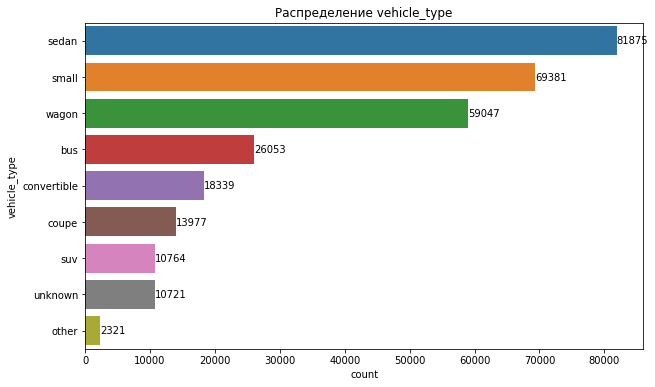

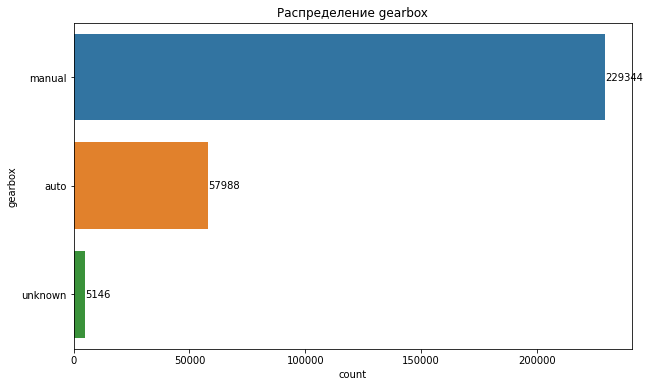

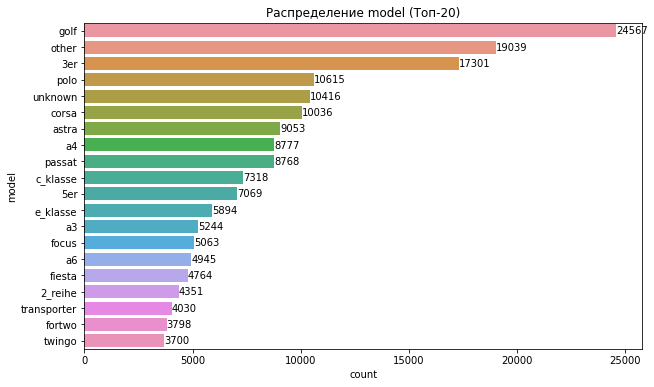

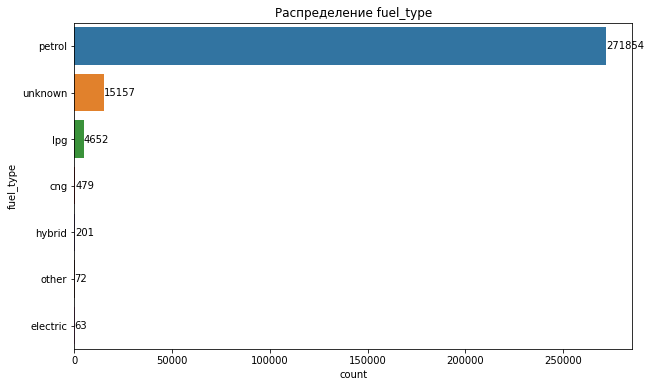

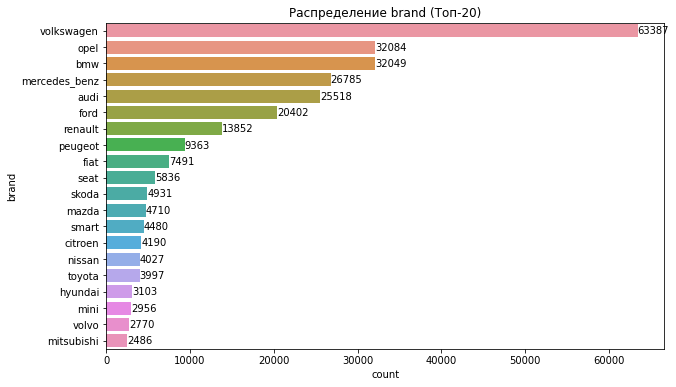

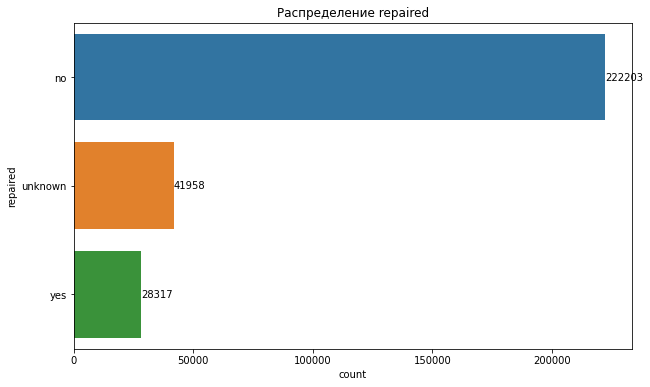

In [31]:
for col in cat_col:
    # Получаем топ-20 самых частых значений
    if data[col].nunique() > 20:
        top_20 = data[col].value_counts().nlargest(20).index
        filtered_data = data[data[col].isin(top_20)]
    else:
        filtered_data = data
    
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(
        y=filtered_data[col],
        order=filtered_data[col].value_counts().index  # Сортируем по частоте
    )
    plt.title(f'Распределение {col}' + (' (Топ-20)' if data[col].nunique() > 20 else ''))
    
    # Добавляем подписи к каждому столбцу вручную
    for p in ax.patches:
        width = p.get_width()  # Получаем ширину столбца (количество наблюдений)
        ax.text(
            width + 0.1,  # x-координата текста (немного правее столбца)
            p.get_y() + p.get_height() / 2,  # y-координата текста (по центру столбца)
            f'{int(width)}',  # Текст (количество наблюдений)
            va='center'  # Выравнивание по вертикали
        )
    
    plt.show()

###  Вывод

- Перевели названия столбцов в змеиный регистр
- Удалили 4 явных дубликата
- Удалили признаки, которые не помогут в определении стоимости автомобиля
- Заполнили пропуски заглушкой `unknown`
- В признаке `fuel_type` переименовали `gasoline` в `petrol`, поскольку оба означают "бензин" 
- Удалили выбросы в численных параметрах

## Корреляция данных

In [32]:
phik_data = data.phik_matrix(interval_cols=num_col)

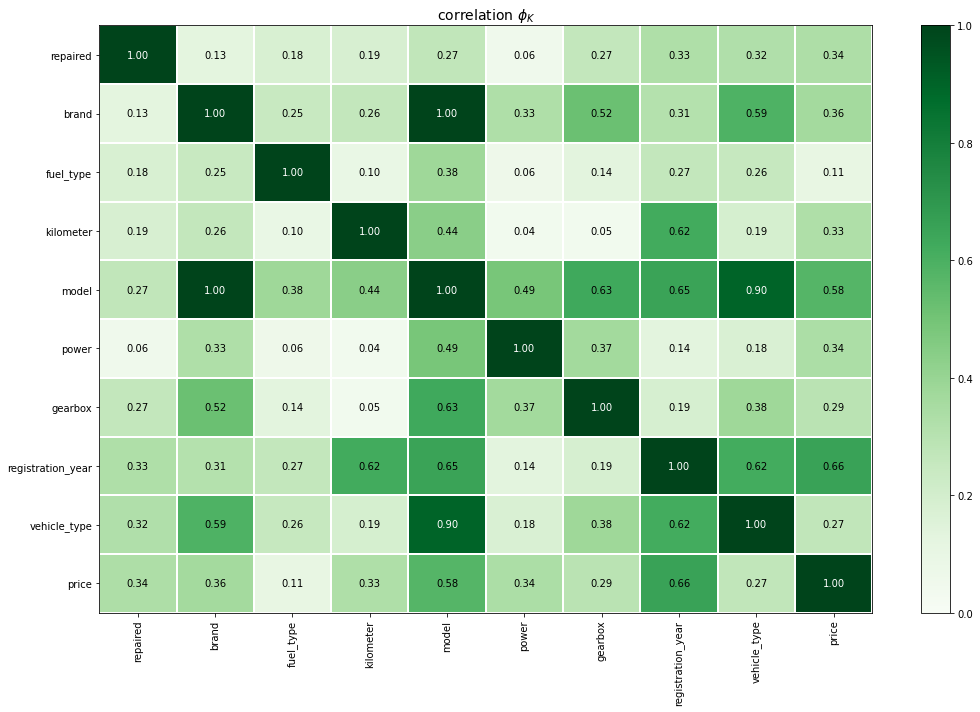

In [33]:
plot_correlation_matrix(phik_data.values, 
                        x_labels=phik_data.columns, 
                        y_labels=phik_data.index,
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 10))

Параметры `brand` и `model` мультиколлинеарны, объединим их в один параметр `brand_model`.

In [34]:
data['brand_model'] = data['brand'] + '_' + data['model']
data = data.drop(columns=['brand', 'model'])

In [35]:
data=data.reset_index(drop=True)

In [36]:
data

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,repaired,brand_model
0,18300,coupe,2011,manual,190,125000,petrol,yes,audi_unknown
1,9800,suv,2004,auto,163,125000,petrol,unknown,jeep_grand
2,1500,small,2001,manual,75,150000,petrol,no,volkswagen_golf
3,3600,small,2008,manual,69,90000,petrol,no,skoda_fabia
4,650,sedan,1995,manual,102,150000,petrol,yes,bmw_3er
...,...,...,...,...,...,...,...,...,...
292473,5250,unknown,2016,auto,150,150000,unknown,no,alfa_romeo_159
292474,3200,sedan,2004,manual,225,150000,petrol,yes,seat_leon
292475,1199,convertible,2000,auto,101,125000,petrol,no,smart_fortwo
292476,9200,bus,1996,manual,102,150000,petrol,no,volkswagen_transporter


In [37]:
phik_data = data.phik_matrix(interval_cols=num_col)

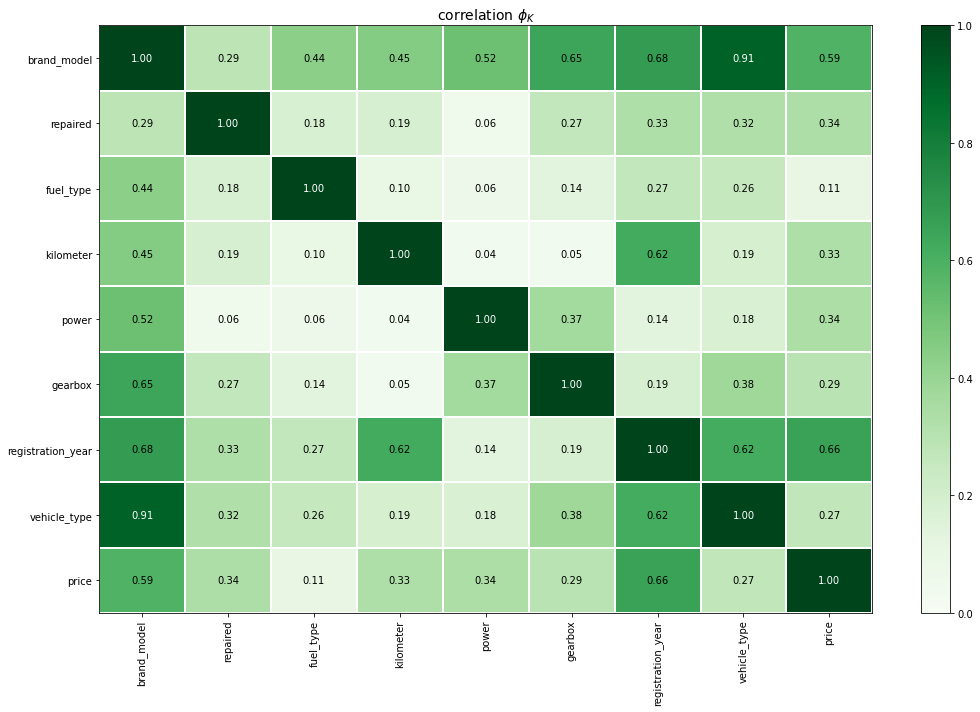

In [38]:
plot_correlation_matrix(phik_data.values, 
                        x_labels=phik_data.columns, 
                        y_labels=phik_data.index,
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 10))

###  Вывод

**1. Наиболее значимые факторы для цены (`price`):**  
- **`registration_year` (0.66)** – самая сильная корреляция. Чем новее автомобиль, тем выше его цена.  
- **`brand_model` (0.59)** – модель автомобиля важна, так как премиальные и популярные бренды стоят дороже.  

**2. Умеренное влияние:**  
- **`power` (0.34)** – мощность двигателя влияет на стоимость: более мощные автомобили дороже.  
- **`kilometer` (0.33)** – пробег влияет на цену, но слабее, чем год выпуска. Чем больше пробег, тем ниже стоимость.  
- **`repaired` (0.34)** – наличие ремонта немного снижает цену (логично, так как это может указывать на проблемы с авто).  

**3. Слабые или незначимые факторы:**  
- **`fuel_type` (0.11)** – тип топлива (бензин/дизель/электричество) почти не влияет на цену.  
- **`gearbox` (0.29)** – коробка передач (автомат/механика) имеет небольшое влияние.  
- **`vehicle_type` (0.27)** – тип кузова (седан, внедорожник и т. д.) слабо коррелирует с ценой.  

## Обучение моделей

Выберем следующие модели:
- `LinearRegression`
- `RandomForestRegressor`
- `DecisionTreeRegressor`
- `LGBMRegressor`

In [39]:
# Разделение на признаки и целевую переменную
X = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

# Определение типов признаков
categorical_features = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'brand_model']
ordinal_features = ['registration_year', 'kilometer']
numeric_features = ['power']

In [40]:
# Создаем преобразователь для OHE категориальных признаков
preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features + ordinal_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Создаем пайплайн для LinearRegression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor_ohe),
    ('regressor', LinearRegression())
])

# Обучение модели
start_train = time.time()
lr_pipeline.fit(X_train, y_train)
lr_train_time = time.time() - start_train

# Предсказание на валидации
start_pred = time.time()
y_val_pred = lr_pipeline.predict(X_val)
lr_pred_time = time.time() - start_pred

# Оценка качества
lr_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f"LinearRegression - RMSE: {lr_rmse:.2f}")
print(f"Время обучения: {lr_train_time:.4f} сек")
print(f"Время предсказания: {lr_pred_time:.4f} сек")

LinearRegression - RMSE: 2736.35
Время обучения: 0.9020 сек
Время предсказания: 0.3106 сек


In [41]:
def train_and_evaluate(X_train, y_train, X_val, y_val, grid_search):
    """
    Обучает модель с подбором гиперпараметров и оценивает его производительность
    
    """
    print("Начинаем подбор гиперпараметров...")
    grid_search.fit(X_train, y_train)
    
    # Замер времени обучения
    start_train = time.time()
    grid_search.best_estimator_.fit(X_train, y_train)
    train_time = time.time() - start_train
    
    # Лучшие параметры
    print("\nЛучшие параметры:")
    print(grid_search.best_params_)
    
    # Замер времени предсказания
    start_pred = time.time()
    y_val_pred = grid_search.best_estimator_.predict(X_val)
    pred_time = time.time() - start_pred
    
    # Оценка качества
    rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    print(f"\nRandomForestRegressor - RMSE: {rmse:.2f}")
    print(f"Время обучения: {train_time:.4f} сек")
    print(f"Время предсказания: {pred_time:.4f} сек")
    
    return {
        'best_params': grid_search.best_params_,
        'rmse': rmse,
        'train_time': train_time,
        'prediction_time': pred_time,
        'model': grid_search.best_estimator_
    }

In [42]:
# Препроцессор для числовых и категориальных признаков
preprocessor_oe = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features + ordinal_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ])

# Пайплайн с препроцессором и моделью
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_oe),
    ('regressor', RandomForestRegressor(random_state=RANDOM_STATE))
])

# Сетка гиперпараметров 
param_grid = {
    'regressor__n_estimators': [50],
    'regressor__max_depth': [None, 10],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1]
}

# Настройка GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=3,  
    scoring='neg_mean_squared_error',
    n_jobs=-1,  
    verbose=1 
)

In [43]:
rf_results = train_and_evaluate(X_train, y_train, X_val, y_val, grid_search_rf)

Начинаем подбор гиперпараметров...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Лучшие параметры:
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}

RandomForestRegressor - RMSE: 1538.11
Время обучения: 15.4759 сек
Время предсказания: 1.0214 сек


In [44]:
# Пайплайн с препроцессором и моделью
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor_ohe),
    ('regressor', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = {
    'regressor__max_depth': [None, 10],
    'regressor__min_samples_split': [2, 10],
    'regressor__min_samples_leaf': [1]
}

grid_search_dt = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=param_grid,
    cv=2,  
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    pre_dispatch='2*n_jobs',
    error_score='raise',
    refit=True  
)

In [45]:
dt_results = train_and_evaluate(X_train, y_train, X_val, y_val, grid_search_dt)

Начинаем подбор гиперпараметров...
Fitting 2 folds for each of 4 candidates, totalling 8 fits

Лучшие параметры:
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10}

RandomForestRegressor - RMSE: 1738.14
Время обучения: 16.5120 сек
Время предсказания: 0.1399 сек


In [46]:
# Преобразуем категориальные признаки в тип 'category'
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

# Создаем базовую модель LGBMRegressor
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)

# Определяем сетку параметров для поиска
param_grid = {
    'num_leaves': [31, 63], 
    'learning_rate': [0.01, 0.05]
}

# Создаем GridSearchCV
grid_search_lgb = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [47]:
lgb_results = train_and_evaluate(X_train, y_train, X_val, y_val, grid_search_lgb)

Начинаем подбор гиперпараметров...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Лучшие параметры:
{'learning_rate': 0.05, 'num_leaves': 63}

RandomForestRegressor - RMSE: 1567.48
Время обучения: 6.0016 сек
Время предсказания: 0.8015 сек


###  Вывод

Обучили модели:
- `LinearRegression`
- `RandomForestRegressor`
- `DecisionTreeRegressor`
- `LGBMRegressor`

По каждой модели полцчило характеристики:
- метрика `RMSE`
- время обучения
- время предсказания

## Анализ моделей

In [48]:
def compare_models_results(lr_rmse, lr_train_time, lr_pred_time, *results_list):
    # Формируем таблицу результатов
    table_results = [
        ["LinearRegression", f"{lr_rmse:.2f}", f"{lr_train_time:.4f}", f"{lr_pred_time:.4f}"]
    ]
    
    for model_name, results in results_list:
        table_results.append([
            model_name,
            f"{results['rmse']:.2f}",
            f"{results['train_time']:.4f}",
            f"{results['prediction_time']:.4f}"
        ])
    
    # Вывод таблицы сравнения
    print("\nСравнение моделей:")
    print("-" * 65)
    print(f"{'Модель':<25} {'RMSE':<10} {'Время обучения':<20} {'Время предсказания'}")
    print("-" * 65)
    for row in table_results:
        print(f"{row[0]:<25} {row[1]:<10} {row[2] + ' сек':<20} {row[3] + ' сек'}")

In [49]:
# Сравниваем модели
compare_models_results(
    lr_rmse, lr_train_time, lr_pred_time,
    ("DecisionTree", dt_results),
    ("RandomForest", rf_results),
    ("LightGBM", lgb_results)
)


Сравнение моделей:
-----------------------------------------------------------------
Модель                    RMSE       Время обучения       Время предсказания
-----------------------------------------------------------------
LinearRegression          2736.35    0.9020 сек           0.3106 сек
DecisionTree              1738.14    16.5120 сек          0.1399 сек
RandomForest              1538.11    15.4759 сек          1.0214 сек
LightGBM                  1567.48    6.0016 сек           0.8015 сек


In [83]:
# Предсказание на тестовой выборке
start_test_pred = time.time()
y_test_pred = lr_pipeline.predict(X_test)
lr_test_pred_time = time.time() - start_test_pred

# Оценка качества на тестовой выборке
lr_test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"LinearRegression - Тестовый RMSE: {lr_test_rmse:.2f}")
print(f"Время предсказания на тестовой выборке: {lr_test_pred_time:.4f} сек")

LinearRegression - Тестовый RMSE: 2746.77
Время предсказания на тестовой выборке: 0.1195 сек


###  Вывод

Исходя из требований заказчика по скорости обучения, придсказания и качества модели, рекомендуем модель `LinearRegression`, поскольку она имеет самые высокие характеристики: `RMSE` - 2736.35, Время обучения - 0.9020 сек, Время предсказания - 0.3106 сек. Тестовый `RMSE`: 2746.77, Время предсказания на тестовой выборке: 0.1195 сек.

##  Общий вывод

В данном проекте мы построили модель для определения рыночной стоимости автомобиля. 

**Основные шаги:**

**1) Загрузка данных.**

**2) Изучение данных.**
1. **Объем данных**:
   - В датасете содержится 354,369 объявлений о продаже автомобилей.
   - Данные содержат 16 признаков, включая информацию о цене, характеристиках автомобиля, датах и местоположении.

2. **Пропуски данных**:
     - `VehicleType` (37,490 пропусков)
     - `Repaired` (71,154 пропусков)
     - `FuelType` (32,895 пропусков)
     - `Gearbox` (19,833 пропусков)
     - `Model` (19,705 пропусков)

3. **Дубликаты**:
   - Обнаружено всего 4 явных дубликата.

4. **Анализ числовых признаков**:
   - **Price (цена)**:
     - Средняя цена составляет около 4,416, но есть значительный разброс (std=4,514).
     - Минимальная цена равна 0, что может указывать на ошибки или нестандартные предложения (например, дарение).
     - 75% объявлений имеют цену до 6,400, но максимальная цена достигает 20,000.
   - **RegistrationYear (год регистрации)**:
     - Средний год регистрации - 2004, но есть аномалии (min=1000, max=9999), которые требуют очистки.
   - **Power (мощность двигателя в л.с.)**:
     - Средняя мощность - 110 л.с., но есть экстремальные значения (max=20,000), которые явно ошибочны.
   - **Kilometer (пробег)**:
     - Средний пробег - 128,211 км, при этом 75% автомобилей имеют пробег 150,000 км или меньше.
   - **NumberOfPictures**:
     - Все значения равны 0, что делает этот признак бесполезным для анализа.

5. **Типы данных**
   - Временные данные следует преобразовать из строкового формата в `datetime`.  

**3) Подготовка выборки для обучения моделей.**
- Перевели названия столбцов в змеиный регистр
- Удалили 4 явных дубликата
- Удалили признаки, которые не помогут в определении стоимости автомобиля
- Заполнили пропуски заглушкой `unknown`
- В признаке `fuel_type` переименовали `gasoline` в `petrol`, поскольку оба означают "бензин" 
- Удалили выбросы в численных параметрах
- Корреляционный анализ:
1. Наиболее значимые факторы для цены (`price`):
- **`registration_year` (0.66)** – самая сильная корреляция. Чем новее автомобиль, тем выше его цена.  
- **`brand_model` (0.58)** – модель автомобиля важна, так как премиальные и популярные бренды стоят дороже.  

2. Умеренное влияние:
- **`power` (0.34)** – мощность двигателя влияет на стоимость: более мощные автомобили дороже.  
- **`kilometer` (0.33)** – пробег влияет на цену, но слабее, чем год выпуска. Чем больше пробег, тем ниже стоимость.  
- **`repaired` (0.34)** – наличие ремонта немного снижает цену (логично, так как это может указывать на проблемы с авто).  

3. Слабые или незначимые факторы: 
- **`fuel_type` (0.11)** – тип топлива (бензин/дизель/электричество) почти не влияет на цену.  
- **`gearbox` (0.29)** – коробка передач (автомат/механика) имеет небольшое влияние.  
- **`vehicle_type` (0.27)** – тип кузова (седан, внедорожник и т. д.) слабо коррелирует с ценой.   


**4) Обучение разных моделей, одна из которых — LightGBM, как минимум одна — не бустинг.**
Обучили модели:
- `LinearRegression`
- `RandomForestRegressor`
- `DecisionTreeRegressor`
- `LGBMRegressor`

По каждой модели полцчило характеристики:
- метрика `RMSE`
- время обучения
- время предсказания

**5) Анализ времени обучения, времени предсказания и качества моделей.**

**6) Опираясь на критерии заказчика, выбор лучшей модели, проверка её качества на тестовой выборке.**

Исходя из требований заказчика по скорости обучения, придсказания и качества модели, рекомендуем модель `LinearRegression`, поскольку она имеет самые высокие характеристики: `RMSE` - 2736.35, Время обучения - 0.9020 сек, Время предсказания - 0.3106 сек. Тестовый `RMSE`: 2746.77, Время предсказания на тестовой выборке: 0.1195 сек.